In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt


### code for loading and partitioning the riding mower data, and plotting scatter plot

In [3]:
mower_df = pd.read_csv("RidingMowers.csv")
mower_df.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


In [4]:
mower_df['Number'] = mower_df.index+1
mower_df.head()

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5


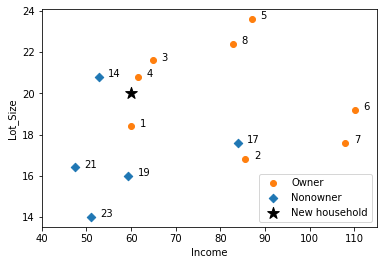

In [5]:
trainData, validData = train_test_split(mower_df, test_size = 0.4, random_state=26)

## new household
newHousehold = pd.DataFrame({'Income':[60], 'Lot_Size':[20]})

## scatter plot
fig, ax = plt.subplots()

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='Owner', color="C1")

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner', color='C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')
plt.ylabel('Lot_Size')
for _, row in trainData.iterrows(): # iterrows : **(🔆)참고
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))
    # ax.annotate : 그래프 안에 주석 넣음 / 저 점마다 뜨는 숫자 ㅇㅇ
    # ax.annotate(넣을 주석내용, 위치좌표)
handles, labels = ax.get_legend_handles_labels()
# .get_legend_handles_labels() <-- Return: This function return the handles and labels for legend.
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

In [6]:
# ** 🔆 Dataframe.iterrows() : 데이터프레임을 이터러블한 행 단위 튜플 형태로 만들어준다.
for i, row in trainData.iterrows():
    if i == 20:
        break
    print(i) # 인덱스 번호만 저장됨
    print(row) # 관측이 저장됨

5
Income       110.1
Lot_Size      19.2
Ownership    Owner
Number           6
Name: 5, dtype: object
3
Income        61.5
Lot_Size      20.8
Ownership    Owner
Number           4
Name: 3, dtype: object
7
Income        82.8
Lot_Size      22.4
Ownership    Owner
Number           8
Name: 7, dtype: object


### code for normalizing data and finding nearest neighbors

In [7]:
scaler = preprocessing.StandardScaler() # 정규화
scaler.fit(trainData[['Income', 'Lot_Size']]) # Note the use of an array of columns names

# Transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income','Lot_Size']]),
                                    columns=['zIncome','zLot_Size']),
                      mower_df[['Ownership', 'Number']]], axis=1)
mowerNorm.head()

,zIncome,zLot_Size,Ownership,Number
0,-0.477910,-0.174908,Owner,1
1,0.680365,-0.787085,Owner,2
2,-0.259882,1.049447,Owner,3
3,-0.409776,0.743358,Owner,4
4,0.748499,1.814668,Owner,5


In [8]:
trainNorm = mowerNorm.iloc[trainData.index] 
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), columns=['zIncome', 'zLot_Size'])

In [9]:
# Use NearestNeighbors from scikit-learn to compute knn  (n=3일 때)
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(distances, indices) # indices : 가장 거리가 가까운 데이터의 위치 번호
# 가장 거리가 가까운 셋

[[0.31358009 0.44793643 0.61217726]] [[1 8 7]]


In [10]:
print(trainNorm.iloc[indices[0], :]) 
# 세개 중 두개가 Owner이므로 다수결로 인해 newHousehold의 Ownership은 'Owner'로 결정

     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


### code for measuring the accuracy of different k values on validation set

In [14]:
train_x

,zIncome,zLot_Size
5,1.797760,0.131181
3,-0.409776,0.743358
7,0.557724,1.355535
20,-1.050235,-0.940129
18,-0.505164,-1.093174
2,-0.259882,1.049447
4,0.748499,1.814668
0,-0.477910,-0.174908
13,-0.804953,0.743358
22,-0.886713,-1.858395


In [11]:
train_x = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_x = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y)
    results.append({
        'k':k, 'accuracy':accuracy_score(valid_y, knn.predict(valid_x))
    })
# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

# k = 4일떄 가장 작으면서도 높은 accurac를 가짐 -> k=4 선택!

,k,accuracy
0,1,0.6
1,2,0.7
2,3,0.8
3,4,0.9
4,5,0.7
5,6,0.9
6,7,0.9
7,8,0.9
8,9,0.9
9,10,0.8


### code for running the k-NN algorithm to classify the new household

In [51]:
# Retrain with full dataset
# k가 정해지고, 진짜 k-nn할 때는 train, valid 합쳐서 모델 적용 시킴
mower_x = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_x, mower_y) # fit

distance, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distance', distance)
print('Indices', indices)
print(mowerNorm.iloc[indices[0],:])
# 3:1 다수결로 Owner됨

['Owner']
Distance [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1
